In [35]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

from pathlib import Path

In [36]:
sns.set_theme(style="darkgrid")

In [37]:
PROBABILITIES_DIR = Path("../../data/probabilities")

In [38]:
# load all probabilities into a dataframe

df_dict = {
    "simulation": [],
    "replica": [],
    "sample_size": [],
    "tree": [],
    "probability": [],
    "method": [],
    "newick": [],
}

for file in PROBABILITIES_DIR.glob("*.csv"):
    name_parts = file.stem.split("-")
    simulation_name = "-".join(name_parts[:-3])
    replica_name = name_parts[-3]
    sample_name = name_parts[-2]
    method_name = name_parts[-1]

    with open(file, "r") as handle:
        for line in handle:
            parts = line.strip().split(",") 
            tree_name = parts[0]
            probability = parts[1]

            df_dict["simulation"].append(simulation_name)
            df_dict["replica"].append(replica_name)
            df_dict["sample_size"].append(int(sample_name))
            df_dict["tree"].append(tree_name)
            df_dict["probability"].append(float(probability))
            df_dict["method"].append(method_name)

            if len(parts) > 2:
                df_dict["newick"].append("-".join(parts[2:]))
            else:
                df_dict["newick"].append("")

df = pd.DataFrame(df_dict)

In [ ]:
# calculate the absolute error between the golden probability and the probability of the simulation

golden_df = df[df["method"] == "golden"]
df["golden_probability"] = df.merge(golden_df, on=["simulation", "replica", "tree"], how="left")["probability_y"]
df["absolute_error"] = (df.golden_probability - df.probability).abs()

In [ ]:
# determine the trees within credibility intervals
unique_binary_trees = golden_df.drop_duplicates(["simulation", "replica", "newick"])
unique_binary_trees = unique_binary_trees.sort_values("probability", inplace=False)
unique_binary_trees["cum_probability"] = (
    unique_binary_trees
    [["simulation", "replica", "probability"]]
    .groupby(["simulation", "replica"])
    ["probability"]
    .cumsum()
)

credibility_50_trees = unique_binary_trees[0.5 < unique_binary_trees.cum_probability]
credibility_50_newick = set(credibility_50_trees.newick)

golden_df["50_credible"] = golden_df.newick.isin(credibility_50_newick)
df["50_credible"] = df.merge(golden_df, on=["simulation", "replica", "tree"], how="left")["50_credible"]

/var/folders/f_/r0jt4c1153v7d286lm9gbgx80000gn/T/ipykernel_24824/4064625578.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  golden_df["50_credible"] = golden_df.newick.isin(credibility_50_newick)


Text(0, 0.5, 'MAE')

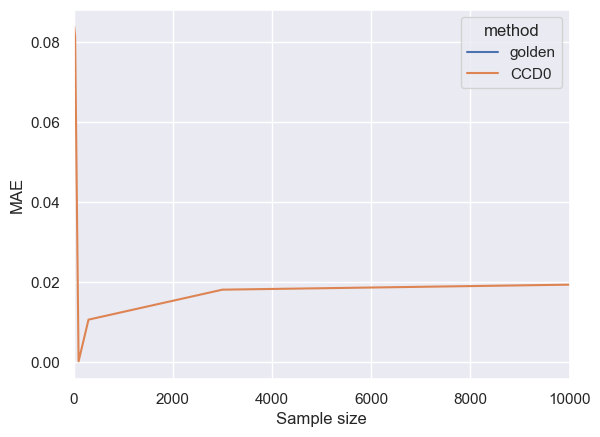

In [ ]:
sns.lineplot(data=df[df["50_credible"]], x="sample_size", y="absolute_error", estimator="median", errorbar=None, hue="method")
plt.xlabel("Sample size")
plt.xlim([0, 10_000])
plt.ylabel("MAE")